# Home Equity Loan Default Prediction Model

### In this notebook a model will be trained of home equity loan to predict whether the user will be default

## NOTE: You need to install all the following below libraries with "pip install 'library_name' " in order to run all the cells on this notebook.
e.g: "*pip install numpy* "

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode,plot,iplot
import plotly_express as px
%matplotlib inline

init_notebook_mode(connected=True)
cf.go_offline()# import all the tools we need


# Regular EDA libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns


# we want our plots to appear within notebooks
%matplotlib inline
pd.set_option('display.float_format', lambda x: '%.2f' % x)
sns.set_style("darkgrid")


# Models from scikit-learn & XGboost
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2


# Model Evaluation libraries
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, make_scorer, accuracy_score
from sklearn.metrics import plot_roc_curve
import joblib

In [2]:
# Import the dataset and print the first 5 records
df = pd.read_csv("hmeq.csv")
df.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.00,39025.00,HomeImp,Other,10.50,0.00,0.00,94.37,1.00,9.00,NaN
1,1,1300,70053.00,68400.00,HomeImp,Other,7.00,0.00,2.00,121.83,0.00,14.00,NaN
2,1,1500,13500.00,16700.00,HomeImp,Other,4.00,0.00,0.00,149.47,1.00,10.00,NaN
3,1,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1700,97800.00,112000.00,HomeImp,Office,3.00,0.00,0.00,93.33,0.00,14.00,NaN


## EDA (Exploratory Data Analysis)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   BAD      5960 non-null   int64  
 1   LOAN     5960 non-null   int64  
 2   MORTDUE  5442 non-null   float64
 3   VALUE    5848 non-null   float64
 4   REASON   5708 non-null   object 
 5   JOB      5681 non-null   object 
 6   YOJ      5445 non-null   float64
 7   DEROG    5252 non-null   float64
 8   DELINQ   5380 non-null   float64
 9   CLAGE    5652 non-null   float64
 10  NINQ     5450 non-null   float64
 11  CLNO     5738 non-null   float64
 12  DEBTINC  4693 non-null   float64
dtypes: float64(9), int64(2), object(2)
memory usage: 605.4+ KB


In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
BAD,5960.00,0.20,0.40,0.00,0.00,0.00,0.00,1.00
LOAN,5960.00,18607.97,11207.48,1100.00,11100.00,16300.00,23300.00,89900.00
MORTDUE,5442.00,73760.82,44457.61,2063.00,46276.00,65019.00,91488.00,399550.00
VALUE,5848.00,101776.05,57385.78,8000.00,66075.50,89235.50,119824.25,855909.00
YOJ,5445.00,8.92,7.57,0.00,3.00,7.00,13.00,41.00
DEROG,5252.00,0.25,0.85,0.00,0.00,0.00,0.00,10.00
DELINQ,5380.00,0.45,1.13,0.00,0.00,0.00,0.00,15.00
CLAGE,5652.00,179.77,85.81,0.00,115.12,173.47,231.56,1168.23
NINQ,5450.00,1.19,1.73,0.00,0.00,1.00,2.00,17.00
CLNO,5738.00,21.30,10.14,0.00,15.00,20.00,26.00,71.00


In [5]:
df["BAD"].value_counts()

0    4771
1    1189
Name: BAD, dtype: int64

<AxesSubplot:>

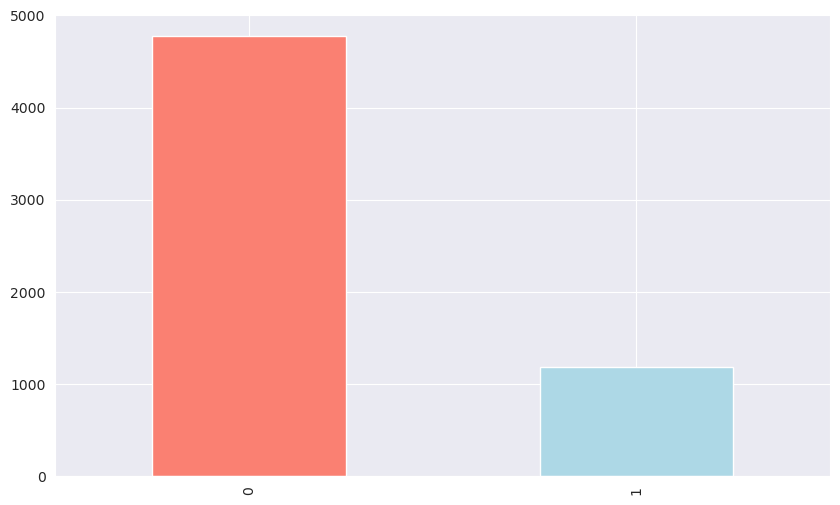

In [6]:
plt.figure(figsize=(10,6))
df["BAD"].value_counts().plot(kind="bar", color=['salmon', 'lightblue'])

In [7]:
df["REASON"].value_counts()


DebtCon    3928
HomeImp    1780
Name: REASON, dtype: int64

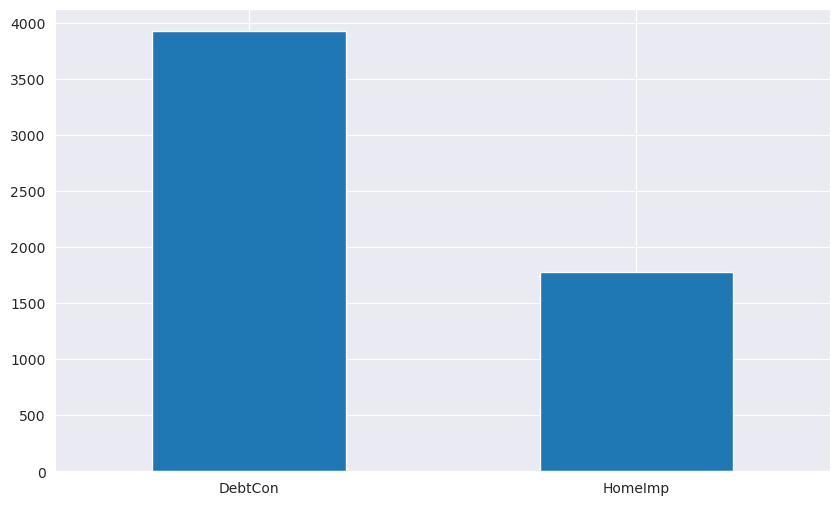

In [8]:
plt.figure(figsize=(10,6))
df["REASON"].value_counts().plot(kind="bar")
plt.xticks(rotation = 0);

<AxesSubplot:>

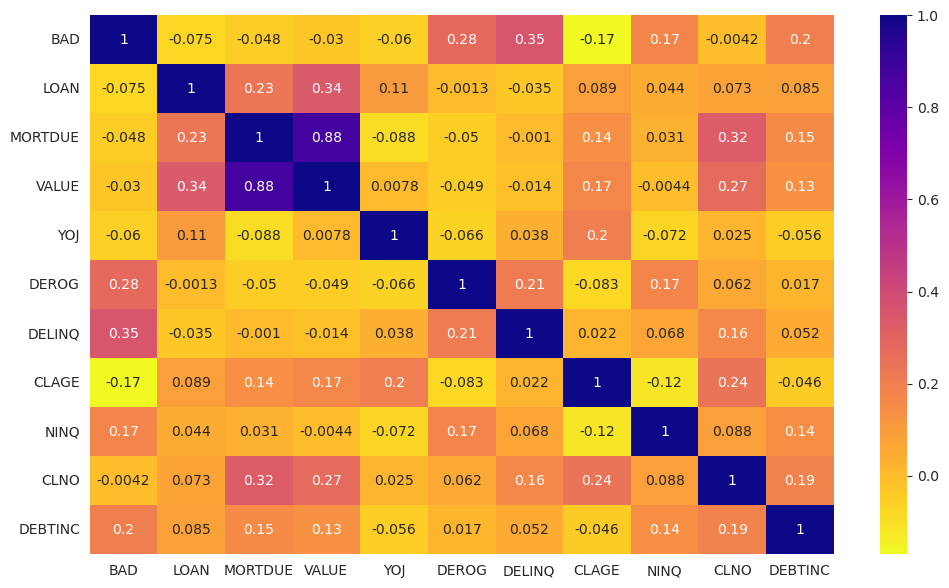

In [10]:
# Let's viualize the corr between independent variables and with dependant (target variable)
plt.figure(figsize=(12,7))
sns.heatmap(df.corr(), annot=True, cmap="plasma_r")

In [11]:
# Let's check it with crosstab 
#(crosstab() function takes two or more lists, pandas series or dataframe columns and returns a frequency of each combination by default)

pd.crosstab(df.BAD, df.REASON)

REASON,DebtCon,HomeImp
BAD,,
0,3183,1384
1,745,396


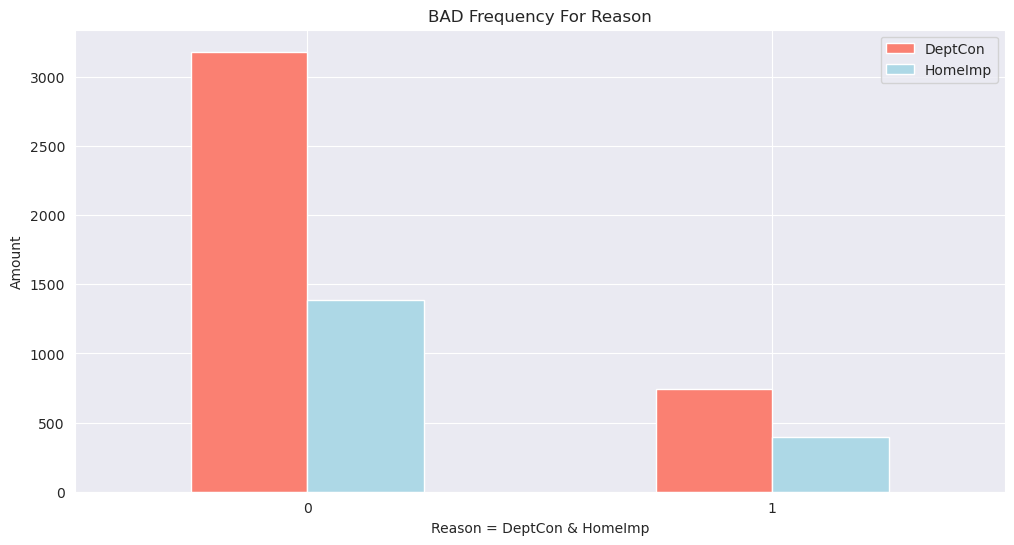

In [12]:
# Create a plot of crosstab for FraudFound and Sex Columns
pd.crosstab(df.BAD, df.REASON).plot(kind="bar",
                                          color=["salmon","lightblue"],
                                          figsize=(12,6))

plt.title("BAD Frequency For Reason")
plt.xlabel("Reason = DeptCon & HomeImp")
plt.ylabel("Amount")
plt.legend(["DeptCon","HomeImp"])
plt.xticks(rotation = 0);

## Build Model

In [13]:
df.isna().value_counts()

BAD    LOAN   MORTDUE  VALUE  REASON  JOB    YOJ    DEROG  DELINQ  CLAGE  NINQ   CLNO   DEBTINC
False  False  False    False  False   False  False  False  False   False  False  False  False      3364
                                                                                        True        883
                                             True   False  False   False  False  False  False       184
              True     False  False   False  False  False  False   False  False  False  False       166
              False    False  False   False  False  True   False   False  False  False  False       125
                                                                                                   ... 
                              True    False  False  False  False   False  True   False  False         1
              True     False  False   True   False  False  False   True   False  False  True          1
              False    True   False   False  False  True   True    True 

* Firstly we need to remove "NaN" or 0 values from our dataset 

In [14]:
print(df['DEBTINC'].unique()=="NaN")
len(df[df['DEBTINC']=="NaN"])

False


/tmp/ipykernel_5326/4071177240.py:1: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



0

In [15]:
df["DEBTINC"].isna().value_counts()

False    4693
True     1267
Name: DEBTINC, dtype: int64

In [16]:
# Make a copy of original dataframe for preprocessing
df_temp = df.copy()
# Finding columns which contains strings
for labels, content in df_temp.items():
    if pd.api.types.is_string_dtype(content):
        print(labels)

REASON
JOB


In [17]:
# Now Let's Fill 0 value with median of the column
df_temp["LOAN"] = df_temp["LOAN"].replace(0,df["LOAN"].median())

In [18]:
df.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.00,39025.00,HomeImp,Other,10.50,0.00,0.00,94.37,1.00,9.00,NaN
1,1,1300,70053.00,68400.00,HomeImp,Other,7.00,0.00,2.00,121.83,0.00,14.00,NaN
2,1,1500,13500.00,16700.00,HomeImp,Other,4.00,0.00,0.00,149.47,1.00,10.00,NaN
3,1,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1700,97800.00,112000.00,HomeImp,Office,3.00,0.00,0.00,93.33,0.00,14.00,NaN


In [19]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   BAD      5960 non-null   int64  
 1   LOAN     5960 non-null   int64  
 2   MORTDUE  5442 non-null   float64
 3   VALUE    5848 non-null   float64
 4   REASON   5708 non-null   object 
 5   JOB      5681 non-null   object 
 6   YOJ      5445 non-null   float64
 7   DEROG    5252 non-null   float64
 8   DELINQ   5380 non-null   float64
 9   CLAGE    5652 non-null   float64
 10  NINQ     5450 non-null   float64
 11  CLNO     5738 non-null   float64
 12  DEBTINC  4693 non-null   float64
dtypes: float64(9), int64(2), object(2)
memory usage: 605.4+ KB


In [20]:
df_temp.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.00,39025.00,HomeImp,Other,10.50,0.00,0.00,94.37,1.00,9.00,NaN
1,1,1300,70053.00,68400.00,HomeImp,Other,7.00,0.00,2.00,121.83,0.00,14.00,NaN
2,1,1500,13500.00,16700.00,HomeImp,Other,4.00,0.00,0.00,149.47,1.00,10.00,NaN
3,1,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1700,97800.00,112000.00,HomeImp,Office,3.00,0.00,0.00,93.33,0.00,14.00,NaN


In [21]:
#For median:
df_temp.fillna(df.median(numeric_only=True).round(1), inplace=True)

In [22]:
df_temp.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.00,39025.00,HomeImp,Other,10.50,0.00,0.00,94.37,1.00,9.00,34.80
1,1,1300,70053.00,68400.00,HomeImp,Other,7.00,0.00,2.00,121.83,0.00,14.00,34.80
2,1,1500,13500.00,16700.00,HomeImp,Other,4.00,0.00,0.00,149.47,1.00,10.00,34.80
3,1,1500,65019.00,89235.50,NaN,NaN,7.00,0.00,0.00,173.50,1.00,20.00,34.80
4,0,1700,97800.00,112000.00,HomeImp,Office,3.00,0.00,0.00,93.33,0.00,14.00,34.80


In [23]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   BAD      5960 non-null   int64  
 1   LOAN     5960 non-null   int64  
 2   MORTDUE  5960 non-null   float64
 3   VALUE    5960 non-null   float64
 4   REASON   5708 non-null   object 
 5   JOB      5681 non-null   object 
 6   YOJ      5960 non-null   float64
 7   DEROG    5960 non-null   float64
 8   DELINQ   5960 non-null   float64
 9   CLAGE    5960 non-null   float64
 10  NINQ     5960 non-null   float64
 11  CLNO     5960 non-null   float64
 12  DEBTINC  5960 non-null   float64
dtypes: float64(9), int64(2), object(2)
memory usage: 605.4+ KB


In [24]:
#Now turn all string into categorical features
for labels, content in df_temp.items():
    if pd.api.types.is_string_dtype(content):
        df_temp[labels] = content.astype("category").cat.as_ordered()

In [25]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   BAD      5960 non-null   int64   
 1   LOAN     5960 non-null   int64   
 2   MORTDUE  5960 non-null   float64 
 3   VALUE    5960 non-null   float64 
 4   REASON   5708 non-null   category
 5   JOB      5681 non-null   category
 6   YOJ      5960 non-null   float64 
 7   DEROG    5960 non-null   float64 
 8   DELINQ   5960 non-null   float64 
 9   CLAGE    5960 non-null   float64 
 10  NINQ     5960 non-null   float64 
 11  CLNO     5960 non-null   float64 
 12  DEBTINC  5960 non-null   float64 
dtypes: category(2), float64(9), int64(2)
memory usage: 524.3 KB


In [26]:
# df_temp["REASON"].fillna(method='bfill', inplace=True)

In [27]:
# df_temp["JOB"].fillna(method='bfill', inplace=True)

In [28]:
# Turn Categorical Features values into numeric
for labels, content in df_temp.items():
    if not pd.api.types.is_numeric_dtype(content):
        # Add binary column to indicate whether sample had missing values 
       #df_temp[labels+"_is_missing"] = pd.isnull(content) # Though we don't have but we could've used if we had missing values
        df_temp[labels] = pd.Categorical(content).codes

In [29]:
df_temp.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.00,39025.00,1,2,10.50,0.00,0.00,94.37,1.00,9.00,34.80
1,1,1300,70053.00,68400.00,1,2,7.00,0.00,2.00,121.83,0.00,14.00,34.80
2,1,1500,13500.00,16700.00,1,2,4.00,0.00,0.00,149.47,1.00,10.00,34.80
3,1,1500,65019.00,89235.50,-1,-1,7.00,0.00,0.00,173.50,1.00,20.00,34.80
4,0,1700,97800.00,112000.00,1,1,3.00,0.00,0.00,93.33,0.00,14.00,34.80


In [30]:
df_temp.describe()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
count,5960.00,5960.00,5960.00,5960.00,5960.00,5960.00,5960.00,5960.00,5960.00,5960.00,5960.00,5960.00,5960.00
mean,0.20,18607.97,73001.04,101540.39,0.26,1.79,8.76,0.22,0.41,179.44,1.17,21.25,34.00
std,0.40,11207.48,42552.73,56869.44,0.52,1.28,7.26,0.80,1.08,83.57,1.65,9.95,7.64
min,0.00,1100.00,2063.00,8000.00,-1.00,-1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.52
25%,0.00,11100.00,48139.00,66489.50,0.00,1.00,3.00,0.00,0.00,117.37,0.00,15.00,30.76
50%,0.00,16300.00,65019.00,89235.50,0.00,2.00,7.00,0.00,0.00,173.50,1.00,20.00,34.80
75%,0.00,23300.00,88200.25,119004.75,1.00,3.00,12.00,0.00,0.00,227.14,2.00,26.00,37.95
max,1.00,89900.00,399550.00,855909.00,1.00,5.00,41.00,10.00,15.00,1168.23,17.00,71.00,203.31


In [31]:
df_temp.drop("REASON", axis=1, inplace=True)

In [32]:
df_temp.drop("JOB", axis=1, inplace=True)

## Spliting Data 

In [33]:
# Split data into X & y
X = df_temp.drop("BAD",axis = 1)
y = df_temp["BAD"]

In [34]:
X

,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1100,25860.00,39025.00,10.50,0.00,0.00,94.37,1.00,9.00,34.80
1,1300,70053.00,68400.00,7.00,0.00,2.00,121.83,0.00,14.00,34.80
2,1500,13500.00,16700.00,4.00,0.00,0.00,149.47,1.00,10.00,34.80
3,1500,65019.00,89235.50,7.00,0.00,0.00,173.50,1.00,20.00,34.80
4,1700,97800.00,112000.00,3.00,0.00,0.00,93.33,0.00,14.00,34.80
...,...,...,...,...,...,...,...,...,...,...
5955,88900,57264.00,90185.00,16.00,0.00,0.00,221.81,0.00,16.00,36.11
5956,89000,54576.00,92937.00,16.00,0.00,0.00,208.69,0.00,15.00,35.86
5957,89200,54045.00,92924.00,15.00,0.00,0.00,212.28,0.00,15.00,35.56
5958,89800,50370.00,91861.00,14.00,0.00,0.00,213.89,0.00,16.00,34.34


In [35]:
y

0       1
1       1
2       1
3       1
4       0
       ..
5955    0
5956    0
5957    0
5958    0
5959    0
Name: BAD, Length: 5960, dtype: int64

In [36]:
# Setup random seed for reproduction
np.random.seed(42)

# Split data into train and test dataset
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size=0.2)

In [37]:
# Let's Check our Train and Test Split
from collections import Counter
print(f"Training target statistics: {Counter(y_train)}")
print(f"Testing target statistics: {Counter(y_test)}")
X_train.shape, X_test.shape, y_train.shape, y_test.shape

Training target statistics: Counter({0: 3844, 1: 924})
Testing target statistics: Counter({0: 927, 1: 265})


((4768, 10), (1192, 10), (4768,), (1192,))

### As we can see our Target Feature is totally unbalanced so we would apply scikit-learn function to balance the weight of classes

In [38]:
#Let's import the function
from sklearn.utils import class_weight
class_weights = dict(zip(np.unique(y_train), class_weight.compute_class_weight(
                                                                        class_weight='balanced',
                                                                        classes= np.unique(y_train), 
                                                                        y = y_train)))
class_weights

{0: 0.6201873048907388, 1: 2.58008658008658}

In [39]:
# Let's put our models into dictionary 
models = {"Logistic Regression": LogisticRegression(class_weight=class_weights,solver = 'liblinear'),
          "KNN": KNeighborsClassifier(),
          "Random Forest Classifier": RandomForestClassifier(class_weight=class_weights),
          "XGboost": XGBClassifier()}

# Let's create a function to fit and later score our models
def fit_score(models, X_train, X_test, y_train, y_test):
    """
    Fits and evaluates the given machine learning models
    """
    # random seed for reproduction
    np.random.seed(42)
    
    # Let's create a empty dictionary to keep model score
    model_score = {}
    
    # Let's loop through the models dictionary
    for name, model in models.items():
        # Fit the model
        model.fit(X_train, y_train)
        # Evaluate the score and append it
        model_score[name] = model.score(X_test,y_test)
    return model_score

In [40]:
model_score = fit_score(models=models,
                        X_train=X_train,
                        X_test=X_test,
                        y_train=y_train,
                        y_test=y_test)
model_score

/home/hazaam/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning:

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.



{'Logistic Regression': 0.7206375838926175,
 'KNN': 0.8087248322147651,
 'Random Forest Classifier': 0.9060402684563759,
 'XGboost': 0.9295302013422819}

In [41]:
# Save into DataFrame
model_compare = pd.DataFrame(model_score,index=["Accuracy"])
model_compare

,Logistic Regression,KNN,Random Forest Classifier,XGboost
Accuracy,0.72,0.81,0.91,0.93


<AxesSubplot:>

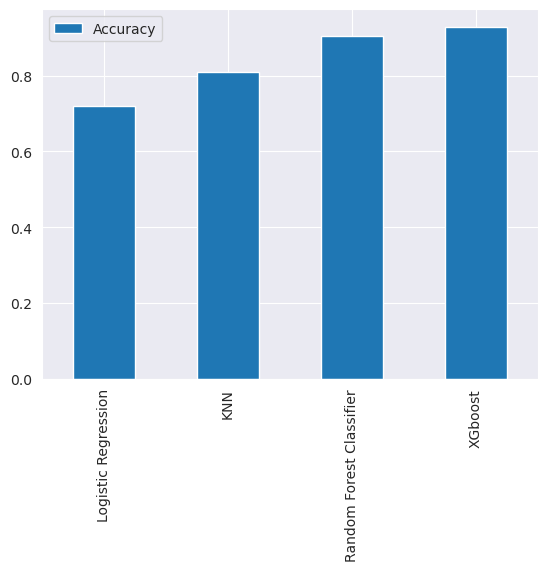

In [42]:
# Let's Plot The Models and Compare
model_compare.T.plot(kind="bar")


## Hyperparameter with RandomizedSearchCV

In [43]:
# Create hyperparameterGrid for RandomForestClassifier
rf_random_grid = {"n_estimators": np.arange(10,1000,50),
                  "max_depth": [None, 3, 5, 10],
                  "min_samples_split": np.arange(2, 20, 2),
                  "min_samples_leaf": np.arange(1, 20, 2)} 

In [44]:
# Setup random seed
np.random.seed(42)

# Setup random hyperparameter search for RandomForestClassifer
rf_rs = RandomizedSearchCV(RandomForestClassifier(class_weight=class_weights),
                           param_distributions=rf_random_grid,
                           cv=5,
                           verbose=True,
                           n_iter=10)

# Fitting random hyperparamter search
rf_rs.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(class_weight={0: 0.6201873048907388,
                                                                  1: 2.58008658008658}),
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([ 10,  60, 110, 160, 210, 260, 310, 360, 410, 460, 510, 560, 610,
       660, 710, 760, 810, 860, 910, 960])},
                   verbose=True)

In [45]:
# Let's Check The Best Parmeters
rf_rs.best_params_

{'n_estimators': 310,
 'min_samples_split': 12,
 'min_samples_leaf': 5,
 'max_depth': None}

In [46]:
# Let's Score the Tunned model
rf_rs.score(X_test, y_test)

0.8984899328859061

In [47]:
# Let's compare it default Models score
model_score

{'Logistic Regression': 0.7206375838926175,
 'KNN': 0.8087248322147651,
 'Random Forest Classifier': 0.9060402684563759,
 'XGboost': 0.9295302013422819}

In [48]:
# Let's Predict on our Optimized model
y_preds = rf_rs.predict(X_test)
y_preds

array([0, 0, 1, ..., 1, 0, 0])

### Evaluating our tunned machine learning classifier, beyond accuracy
* ROC curve and AUC Score
* Confusion matrix
* Classification report
* Precision
* Recall
* F1-Score

and it would be great if Cross-validation used if possible

/home/hazaam/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.



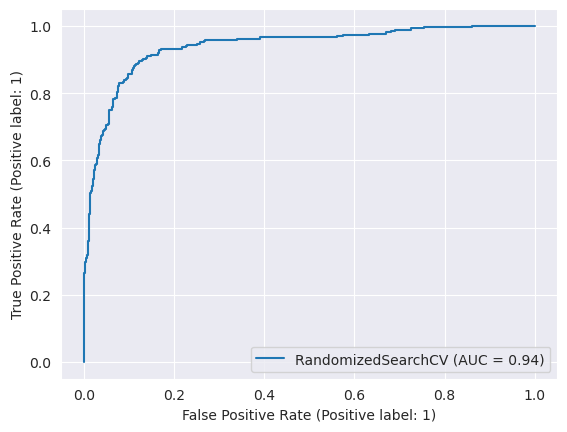

In [49]:
# Let's plot ROC Curve and calculate the AUC metric
plot_roc_curve(rf_rs, X_test,y_test);

In [50]:
print(confusion_matrix(y_test,y_preds))

[[858  69]
 [ 52 213]]


In [51]:
print(classification_report(y_test,y_preds));

              precision    recall  f1-score   support

           0       0.94      0.93      0.93       927
           1       0.76      0.80      0.78       265

    accuracy                           0.90      1192
   macro avg       0.85      0.86      0.86      1192
weighted avg       0.90      0.90      0.90      1192



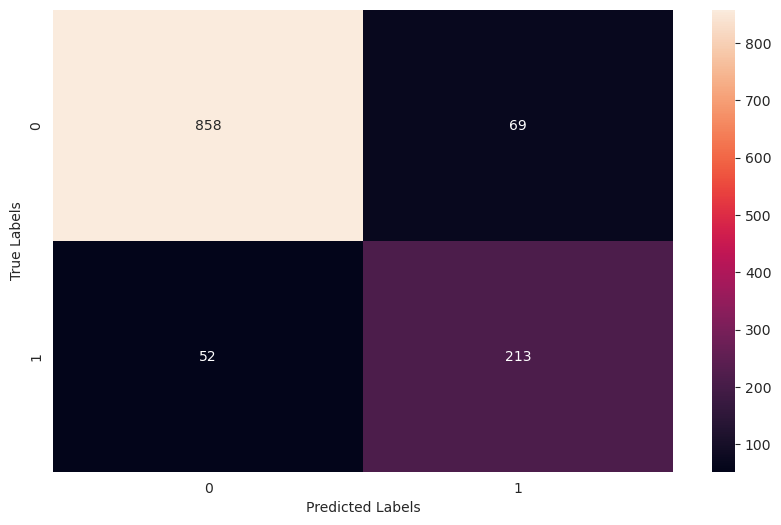

In [52]:
# Let's visualize the confusion matrix

def conf_plot(y_test, y_preds):
    """
    Plots a nice looking heatmap on seaborn
    """
    fix, ax = plt.subplots(figsize=(10,6))
    ax = sns.heatmap(confusion_matrix(y_test, y_preds),
                     annot=True,
                     cbar=True,
                     fmt="g");
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")

conf_plot(y_test, y_preds)  

In [53]:
final_rf_classifier = RandomForestClassifier(n_estimators=310,
                                            min_samples_split=12,
                                            min_samples_leaf=5,
                                            max_depth=None)

In [54]:
final_rf_classifier.fit(X_train, y_train)

RandomForestClassifier(min_samples_leaf=5, min_samples_split=12,
                       n_estimators=310)

In [55]:
y_preds = final_rf_classifier.predict(X_test)
y_preds

array([0, 0, 0, ..., 1, 0, 0])

In [56]:
print(confusion_matrix(y_test,y_preds))

[[895  32]
 [ 83 182]]


In [57]:
print(classification_report(y_test,y_preds));

              precision    recall  f1-score   support

           0       0.92      0.97      0.94       927
           1       0.85      0.69      0.76       265

    accuracy                           0.90      1192
   macro avg       0.88      0.83      0.85      1192
weighted avg       0.90      0.90      0.90      1192



In [58]:
# Check coeffeficient eg.(how the independent variables (X_train) contributes to predict target variable (y))
final_rf_classifier.feature_importances_

array([0.0779871 , 0.06287554, 0.06824609, 0.04680706, 0.07579858,
       0.1190731 , 0.09628222, 0.0413363 , 0.06482877, 0.34676525])

In [59]:
# We would only plot first top 20 features
def plot_features(columns, importances, n=20):
    df_feat = (pd.DataFrame({"features":columns,
                             "features_importances": importances})
          .sort_values("features_importances",ascending=False)
          .reset_index(drop=True))
    
    # Plot the dataframe we created
    fig, ax = plt.subplots(figsize=(12,7))
    ax.barh(df_feat["features"][:n], df_feat["features_importances"][:20])
    ax.set_ylabel("Features")
    ax.set_xlabel("Features Importance")
    ax.invert_yaxis()

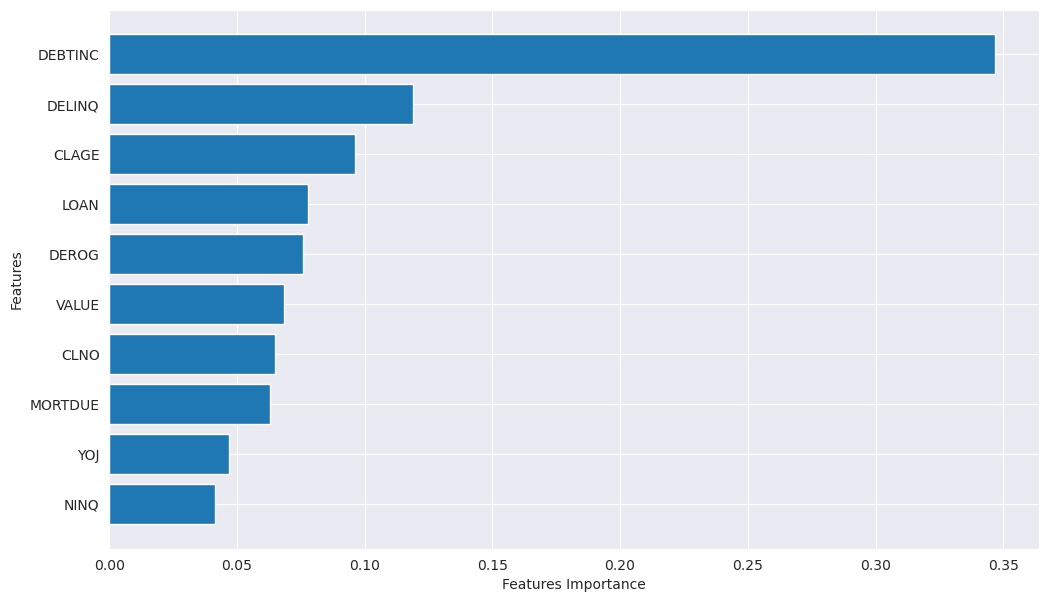

In [60]:
plot_features(X_train.columns, final_rf_classifier.feature_importances_)

# Saving our model

In [61]:
joblib.dump(final_rf_classifier, "home_equity_loan_predictor.joblib")

['home_equity_loan_predictor.joblib']

In [62]:
model = joblib.load("home_equity_loan_predictor.joblib")

In [63]:
model

RandomForestClassifier(min_samples_leaf=5, min_samples_split=12,
                       n_estimators=310)

In [64]:
df.head(20)

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.00,39025.00,HomeImp,Other,10.50,0.00,0.00,94.37,1.00,9.00,NaN
1,1,1300,70053.00,68400.00,HomeImp,Other,7.00,0.00,2.00,121.83,0.00,14.00,NaN
2,1,1500,13500.00,16700.00,HomeImp,Other,4.00,0.00,0.00,149.47,1.00,10.00,NaN
3,1,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1700,97800.00,112000.00,HomeImp,Office,3.00,0.00,0.00,93.33,0.00,14.00,NaN
5,1,1700,30548.00,40320.00,HomeImp,Other,9.00,0.00,0.00,101.47,1.00,8.00,37.11
6,1,1800,48649.00,57037.00,HomeImp,Other,5.00,3.00,2.00,77.10,1.00,17.00,NaN
7,1,1800,28502.00,43034.00,HomeImp,Other,11.00,0.00,0.00,88.77,0.00,8.00,36.88
8,1,2000,32700.00,46740.00,HomeImp,Other,3.00,0.00,2.00,216.93,1.00,12.00,NaN
9,1,2000,NaN,62250.00,HomeImp,Sales,16.00,0.00,0.00,115.80,0.00,13.00,NaN


In [65]:
equity_example = {
    "loan": 88900,
    "mortdue": 57264.00,
    "value": 90185.00	,
    "yoj": 16.00,
    "derog": 0.00,
    "delinq": 0.00,
    "clage": 221.81,
    "ninq": 0.00,
    "clno": 16.00,
    "debtinc": 36.11
}

In [66]:
def return_prediction(model, sample_json):

    loan = sample_json["loan"]
    mortdue = sample_json["mortdue"] 
    value = sample_json["value"] 
    yoj = sample_json["yoj"] 
    derog = sample_json["derog"] 
    delinq = sample_json["delinq"] 
    clage = sample_json["clage"] 
    ninq = sample_json["ninq"] 
    clno = sample_json["clno"] 
    debtinc = sample_json["debtinc"]

    predictor = [[loan, value, mortdue, yoj, derog, delinq, clage, ninq, clno, debtinc]]

    classes = np.array(["Not defaulter", "Defaulter"])

    class_ind = model.predict(predictor) 

    return classes[class_ind]


In [67]:
return_prediction(model, equity_example)

/home/hazaam/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names



array(['Not defaulter'], dtype='<U13')

# Code for deployment

In [68]:
import joblib
import numpy as np

model = joblib.load("home_equity_loan_predictor.joblib")

def return_prediction(model, sample_json):

    loan = sample_json["loan"]
    mortdue = sample_json["mortdue"] 
    value = sample_json["value"] 
    yoj = sample_json["yoj"] 
    derog = sample_json["derog"] 
    delinq = sample_json["delinq"] 
    clage = sample_json["clage"] 
    ninq = sample_json["ninq"] 
    clno = sample_json["clno"] 
    debtinc = sample_json["debtinc"]

    predictor = [[loan, value, mortdue, yoj, derog, delinq, clage, ninq, clno, debtinc]]

    classes = np.array(["Not defaulter", "Defaulter"])

    class_ind = model.predict(predictor) 

    return classes[class_ind]

## Extras

In [69]:
import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode,plot,iplot
%matplotlib inline

In [70]:
init_notebook_mode(connected=True)

In [71]:
cf.go_offline()

In [72]:
#plots for 
plot1 = df_temp.iplot(kind='scatter',x='LOAN', y='DEBTINC',mode='markers',
                        title='Loan against Debt-inome-ratio',
                        xTitle='Loan',
                        yTitle='Debt-inc',)

In [73]:
df.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.00,39025.00,HomeImp,Other,10.50,0.00,0.00,94.37,1.00,9.00,NaN
1,1,1300,70053.00,68400.00,HomeImp,Other,7.00,0.00,2.00,121.83,0.00,14.00,NaN
2,1,1500,13500.00,16700.00,HomeImp,Other,4.00,0.00,0.00,149.47,1.00,10.00,NaN
3,1,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1700,97800.00,112000.00,HomeImp,Office,3.00,0.00,0.00,93.33,0.00,14.00,NaN


In [74]:
#plots for 
df_temp.iplot(kind='line',x='DEBTINC', y='YOJ',mode='markers',
                        title='Value against Debt-inome-ratio',
                        xTitle='DEBTINC',
                        yTitle='YOJ "Years Of Job"')

In [276]:
# Create a plot of crosstab for Reason and Bad Columns to crosscheck
pd.crosstab(df.BAD, df.REASON).iplot(kind="bar",
                                     xTitle='Reason = DeptCon & HomeImp',
                                     yTitle='Amount',
                                     title='BAD Frequency For Reason'
                                    )

In [294]:

df_val1 = df.loc[df["BAD"]== 1].groupby('DEBTINC')['BAD'].agg('sum').sort_values(ascending=False)
df_val1 = pd.DataFrame({'DEBTINC':df_val1.index, 'Number of Cases':df_val1.values})

In [297]:
fig = px.histogram(
    df_val1,
    x='DEBTINC',
    y='Number of Cases',
)
fig

In [269]:
df.BAD.value_counts()

0    4771
1    1189
Name: BAD, dtype: int64

In [251]:
df_val1["Number of Cases"].sum()

1189

In [239]:
df["JOB"].unique()

array(['Other', nan, 'Office', 'Sales', 'Mgr', 'ProfExe', 'Self'],
      dtype=object)